In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import torch
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch.distributions as distr
from collections import defaultdict

In [3]:
# configure matplotlib
# %matplotlib notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (13.5, 13.5) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [4]:
from cdi.data.frey_faces import FreyFacesDataset
from cdi.util.analysis.show_frey_faces import show_examples
from cdi.trainers.complete_mle import CompleteMLE
from cdi.trainers.expectation_maximisation import EM
from cdi.trainers.mc_expectation_maximisation import MCEM

In [5]:
log_path_base = f'../../trained_models/{{}}'

In [6]:
def load_model(method, checkpoint_path):   
    model = None
    if method == 'complete_mle':
        model = CompleteMLE.load_from_checkpoint(checkpoint_path)
    elif method == 'expectation-maximisation':
        model = EM.load_from_checkpoint(checkpoint_path)
    elif method == 'mc-expectation-maximisation':
        model = MCEM.load_from_checkpoint(checkpoint_path)
    else:
        raise Exception(f'Invalid method: {method}')
    
    return model


def load_obs_mean(path):
    return np.load(path, allow_pickle=True)['obs_mean']

# Defaults

In [7]:
original_dataset = FreyFacesDataset('../../data', preprocess=False)

# Simulate from VAE model trained on complete data

In [10]:
dataset_name = 'fcvae_frey_processed/learning_experiments/1'
name = 'fcvae_complete_data'
seed_stamp = 'm20190508_d20200325_20200406_20200407'
which_model = '_ckpt_epoch_1574'
model = load_model('complete_mle', '{}/{}/{}/saved_models/{}.ckpt'.format(log_path_base.format(dataset_name), name, seed_stamp, which_model))
model = model.fa_model

obs_mean = load_obs_mean(log_path_base.format(f'{dataset_name}/{name}/{seed_stamp}/logs/tensors/obs_mean_0.npz'))

In [31]:
seed = 20201016
np.random.seed(seed)
torch.manual_seed(seed)

Z = torch.randn(3000, 10)

mean, log_var = model.decode(Z)
multi_gauss = distr.Normal(loc=mean, scale=torch.exp(log_var/2))

generated_data = multi_gauss.sample()
generated_data = generated_data + obs_mean
generated_data_postprocessed = original_dataset.postprocess(generated_data)
# generated_data_postprocessed = generated_data

To show the examples we clip them to [0,1] range.

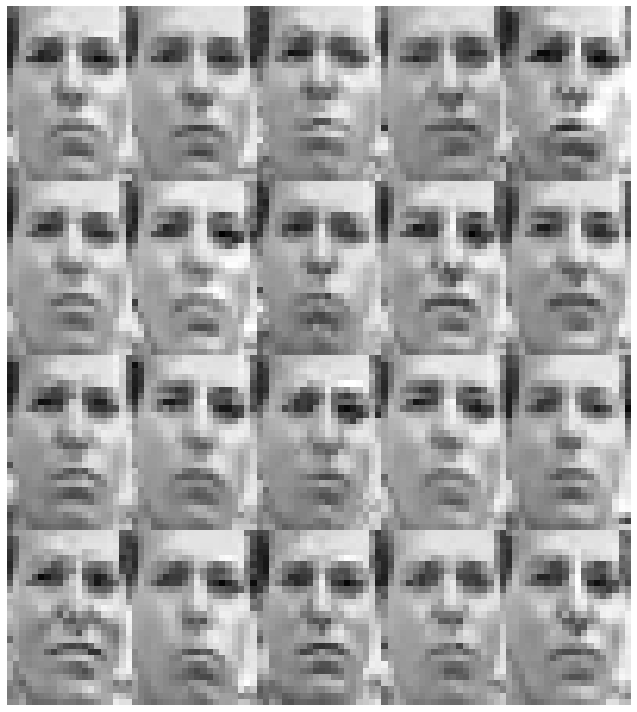

In [40]:
# Show examples
ids = np.random.choice(np.arange(len(generated_data_postprocessed)), 20)
show_data = np.clip(generated_data_postprocessed, 0, 1)[ids].detach().numpy()
# show_data = generated_data_postprocessed[ids].detach().numpy()
mask = np.ones_like(show_data)
show_examples(show_data, mask, n=20, n_cols=5, mask_missing=False)